# Problem Set 2

#### Imports and definition of helper fucntions such as plots

In [1]:
!python -m pip install --upgrade pip
!pip install python-louvain

    100% |████████████████████████████████| 1.4MB 20.3MB/s ta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1


In [2]:
!pip install powerlaw

In [3]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms.community import k_clique_communities
import community as community
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import collections
import operator
import powerlaw as pl
from multiprocessing import Pool
import scipy.sparse as sp
import itertools
import pprint
import matplotlib.style as style 
import random, time
from matplotlib.colors import rgb2hex
import io
sns.set()
style.use('Solarize_Light2')
sns.set_style("whitegrid")


In [4]:
def nx_hist(x, bins, normed = False, xscale = 'linear', yscale = 'linear', use_log = False, title = None, xlabel = 'Degree', ylabel = 'Count'): 
    density = None
    if(normed):
        density = 1
        ylabel = 'Probability'
    fig = plt.figure(figsize=(15,6))
    plt.hist(x, bins=bins, normed=density, log=use_log)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xscale(yscale)
    plt.yscale(yscale)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
def print_in_degree_dist(G):
    degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence) # degree count
    print("Empirical Degree Distribution for network: "+G.name)
    nx_hist(degree_sequence,len(degreeCount))
    nx_hist(degree_sequence,len(degreeCount),yscale='log')  
   # nx_hist(degree_sequence,len(degreeCount),yscale='log',use_log=True) 
    
def print_out_degree_dist(G):
    degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence) # degree count
    print("Empirical Degree Distribution for network: "+G.name)
    nx_hist(degree_sequence,len(degreeCount))
    nx_hist(degree_sequence,len(degreeCount),yscale='log') 
    #nx_hist(degree_sequence,len(degreeCount),yscale='log',use_log=True) 
    
def print_degree_dist(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence) # degree count
    print("Empirical Degree Distribution for network: "+G.name)
    nx_hist(degree_sequence,len(degreeCount))
    nx_hist(degree_sequence,len(degreeCount),yscale='log') 
    #nx_hist(degree_sequence,len(degreeCount),yscale='log',use_log=True) 

def plot_centrality(x,y,xlabel,ylabel,xmin,ymin,xmax,ymax):
    plt.figure(figsize=(15,9))
    plt.scatter(np.array(list(x.values())),np.array(list(y.values())))
    plt.xlim(xmin,xmax)
    #plt.ylim(ymin,ymax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("Centrality Comparison for the selected Measures")
    plt.show()
    
def cc_cdf(cc_dict):
    plt.figure(figsize=(15,10))
    plt.plot(sorted(cc_dict.values()),np.arange(0,len(cc_dict))/len(cc_dict))
    plt.xlabel("Local Clustering Coefficient (c)")
    plt.ylabel("P(x<=c)")
    plt.title("Empirical Clustering Coefficient CDF")
    plt.show()
    return

def w_degree_centrality(G):
    keys = list(nx.get_edge_attributes(G,'weight').keys())
    tot = np.array(list(nx.get_edge_attributes(G,'weight').values())).sum()
    vals = list(np.array(list(dict(G.degree(weight='weight')).values())/tot))
    return dict(zip(keys, vals))
    
def in_degree_centrality(G,weights):
    values_list = list(G.edges.data(weights))
    val_num = np.array([values_list[i][2] for i in range(9651)])
    vals = list(np.array(list(dict(G.in_degree(weight=weights)).values()))/np.sum(val_num))
    keys = list(idc_G.keys())
    return dict(zip(keys, vals))

def out_degree_centrality(G,weights):
    values_list = list(G.edges.data(weights))
    val_num = np.array([values_list[i][2] for i in range(9651)])
    vals = list(np.array(list(dict(G.out_degree(weight=weights)).values()))/np.sum(val_num))
    keys = list(idc_G.keys())
    return dict(zip(keys, vals))

def print_node_data(G,max):
    i = 0
    for n, d in G.nodes(data=True):
        if i < max:
            print(n,d)
        i = i + 1
    return

def ret_nodelist(DM_G,G_GCC,N):

    G_GCC_degs = dict(sorted(G_GCC.degree, key=lambda x: x[1], reverse=True))
    G_GCC_min_degs = dict([(key, value) for key,value in G_GCC_degs.items() if (value == 1)])
    
    #G_GCC_top10_names = [key for key, value in G_GCC_degs.items()][0:N]
    #G_GCC_top10 = [value for key, value in G_GCC_degs.items()][0:N]
    
    print("Top 10 highest degree nodes and values:")
    i = 0
    for k, v in G_GCC_degs.items():
        if i < N:
            print(k,v)
        i = i + 1
    #return [G_GCC_top10_names, G_GCC_top10]

In [5]:
G = nx.read_edgelist('SMS-network.txt')

# 1. Basic Network statistics and degree distribution

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
G_GCC = max(nx.connected_component_subgraphs(G), key=len)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
Empirical Degree Distribution for network: 


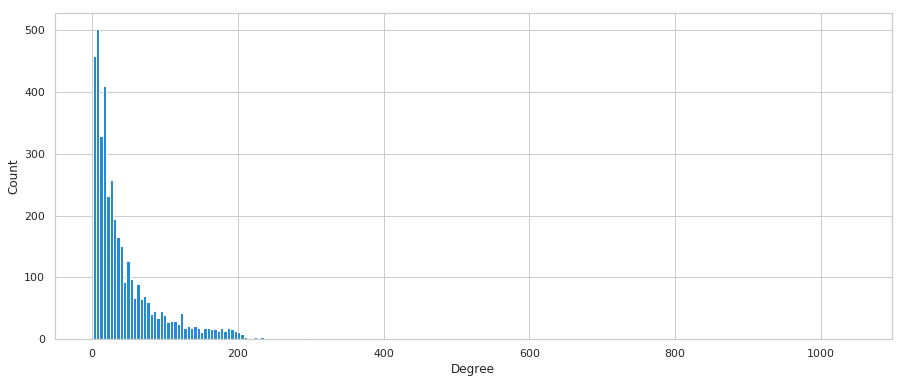

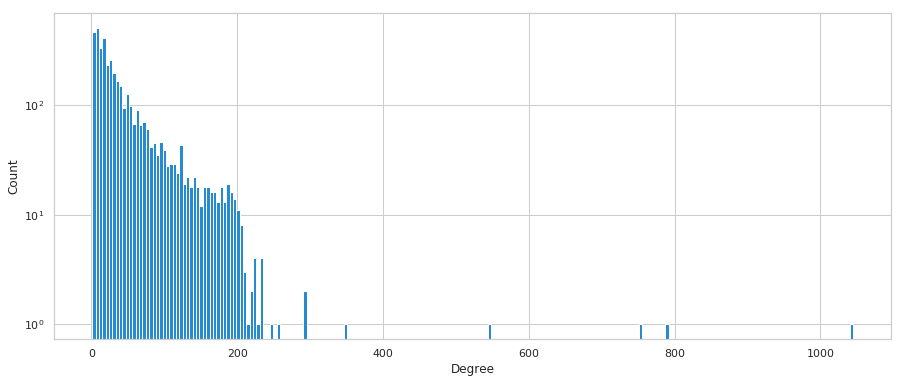

In [8]:
print(nx.info(G_GCC))
print_degree_dist(G_GCC)

In [9]:
def calculate_powerlaw(G_GCC):
    G_deg = sorted([d for n, d in G_GCC.degree()], reverse=True)
    print('{:^30}\t{:^7}'.format('Minimum number of neighbors:', G_deg[0]))
    print('{:^30}\t{:^7}'.format('Maximum number of neighbors:', G_deg[-1]))
    print('{:^30}\t{:^7.3f}'.format('Mean number of neighbors:', sum(G_deg)/len(G_deg)))

    fit_G = pl.Fit(G_deg)

    print("Power Law vs Exponential:")
    R, p = fit_G.distribution_compare('power_law', 'exponential')
    print('R = {:.5f}'.format(R))
    print('p = {:.5f}'.format(p))

    print("Power Law vs Lognormal:")
    R, p = fit_G.distribution_compare('power_law', 'lognormal')
    print('R = {:.5f}'.format(R))
    print('p = {:.5f}'.format(p))

    print("Lognormal vs Exponential:")
    R, p = fit_G.distribution_compare('lognormal_positive', 'exponential')
    print('R = {:.5f}'.format(R))
    print('p = {:.5f}'.format(p))

    plt.figure(figsize=(15,9))
    fig = fit_G.plot_ccdf(linewidth=2, label='Empirical CCDF')
    fit_G.power_law.plot_ccdf(linestyle='--',ax=fig, label='Fitted Powerlaw CCDF')
    fit_G.lognormal_positive.plot_ccdf(linestyle='--',ax=fig, label='Fitted Lognormal CCDF')
    plt.xlabel("Probability")
    plt.ylabel("Number of Neighbors")
    plt.legend()
    plt.show()

    print('Fitted parameter alpha of the power law distribution: {:.3f}'.format(fit_G.power_law.alpha))
    print('Standard error of alpha: {:.3f}'.format(fit_G.power_law.sigma))

 Minimum number of neighbors: 	 1045  
 Maximum number of neighbors: 	   1   
  Mean number of neighbors:   	43.691 
Power Law vs Exponential:
R = 23.37320
p = 0.06533
Power Law vs Lognormal:
R = -0.92839
p = 0.18551
Lognormal vs Exponential:
R = 21.77665
p = 0.05531


Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


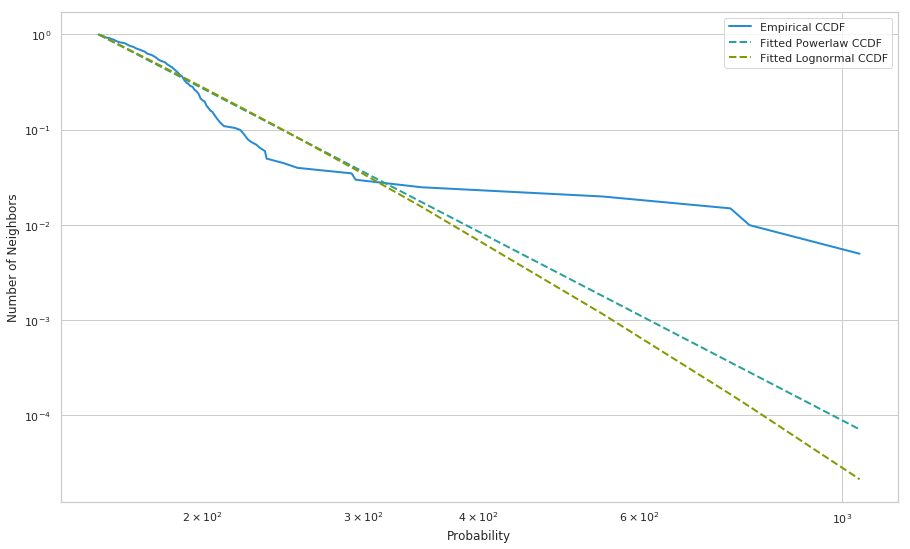

Fitted parameter alpha of the power law distribution: 5.993
Standard error of alpha: 0.351


In [39]:
calculate_powerlaw(G_GCC)

#### Clustering and Other Network Figures

In [11]:
def calculate_clustering(G_GCC):
    clust_G = nx.clustering(G_GCC) #network clustering coeff for all nodes
    C_G = float(sum(clust_G.values())/len(clust_G)) #average clustering coefficient
    T_G = nx.transitivity(G_GCC) #transitivity
    D_G = nx.density(G_GCC) #density
    cc_cdf(clust_G) #clustering coefficient cdf
    print("Average Clustering:",C_G)
    print("Overall Clustering (Transitivity):",T_G)
    print("Network Density",D_G)
    print("Avg Clustering to Density Ratio:",C_G/D_G)
    
    df = pd.DataFrame(columns=['Density','Overall clust','Average clust','Avg Clustering to Density Ratio'])
    df = df.append({'Density':D_G,'Overall clust': T_G, 'Average clust': C_G,'Avg Clustering to Density Ratio' : C_G/D_G }, ignore_index=True)
    return df

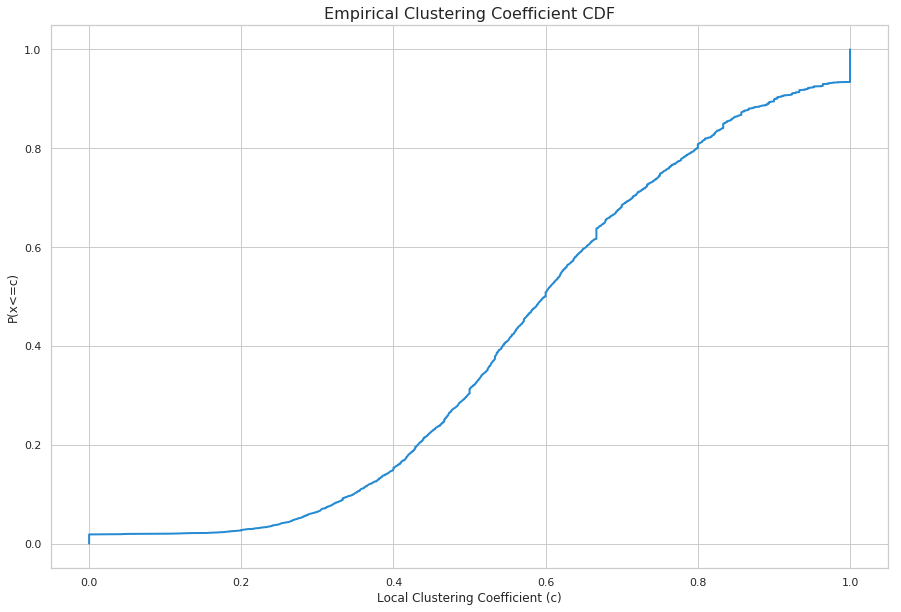

Average Clustering: 0.6055467186200876
Overall Clustering (Transitivity): 0.5191742775433075
Network Density 0.010819963503439287
Avg Clustering to Density Ratio: 55.96568957257624


,Density,Overall clust,Average clust,Avg Clustering to Density Ratio
0,0.01082,0.519174,0.605547,55.96569


In [12]:
df = calculate_clustering(G_GCC)
display(df)

Note: The Floyd Warshall Matrix takes a LONG time to compute.

In [13]:
def calculate_distances(G_GCC,flag,filename):
    if flag:
        DM_G = nx.floyd_warshall_numpy(G_GCC)
        np.savez_compressed(filename, DM_G.astype(int))
    else:
        with np.load(filename) as data:
            DM_G = data['arr_0']
    dia_G = np.max(DM_G) # network diameter
    avg_spl_G = np.sum(DM_G)/(len(G_GCC.nodes)*(len(G_GCC.nodes)-1)) #avg shortest path length
    print("Diameter:",dia_G)
    print("Average Shortest Path Length:",avg_spl_G)
    
    df = pd.DataFrame(columns=['Diameter','Average Shortest Path Length'])
    df = df.append({'Diameter':dia_G,'Average Shortest Path Length': avg_spl_G,}, ignore_index=True)
    display(df)
    return DM_G

In [14]:
DM_G = calculate_distances(G_GCC,0,'dm_mat.npz') 

Diameter: 8
Average Shortest Path Length: 3.6925068496963913


,Diameter,Average Shortest Path Length
0,8.0,3.692507


# 2. Centrality Measures

In [40]:
ret_nodelist(DM_G,G_GCC,10)

Top 10 highest degree nodes and values:
107 1045
1684 792
1912 755
3437 547
0 347
2543 294
2347 291
1888 254
1800 245
1663 235


In [16]:
def print_top_10(D,G): #where G is the graph and D is the centrality measure dict
    df = pd.DataFrame(columns=['Node ID','Centrality Score'])
    #nodeDict = dict(G.nodes(data=True))
    D_sorted = dict(sorted(D.items(), key=operator.itemgetter(1), reverse=True))
    D_list = list(D_sorted)
    L = D_list[0:10]
    #top_10_dict = {k:nodeDict[k] for k in L if k in nodeDict}
    top_10_vals = np.array(list(D_sorted.values())[:10])
    
    #print(top_10_dict)
    i = 0
    for l in L:        
        df = df.append({'Node ID': l, 'Centrality Score':top_10_vals[i]}, ignore_index=True)
        i = i+1
    display(df)

In [17]:
def store_top_200(D,G):
    df = pd.DataFrame(columns=['Node ID','Centrality Score'])
    D_sorted = dict(sorted(D.items(), key=operator.itemgetter(1), reverse=True))
    D_list = list(D_sorted)
    
    S_top200 = D_list[0:200] 
    S_top200_value = np.array(list(D_sorted.values())[:200])
    
    i = 0
    for l in S_top200:        
        df = df.append({'Node ID': l, 'Centrality Score':S_top200_value[i]}, ignore_index=True)
        i = i+1
    return df

In [18]:
#Networkx: Parallel Implementation of Betweenness Centrality
def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def _betmap(G_normalized_weight_sources_tuple):
    """Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    `betweenness_centrality_source`
    """
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [19]:
bc_G = betweenness_centrality_parallel(G_GCC)

In [20]:
dc_G = nx.degree_centrality(G_GCC)
pr_G = nx.pagerank(G_GCC)

In [21]:
ev_G = nx.eigenvector_centrality_numpy(G_GCC)
katz_G = nx.katz_centrality_numpy(G_GCC)

In [22]:
cc_G = nx.closeness_centrality(G_GCC)

Degree vs Unweighted Centralities:


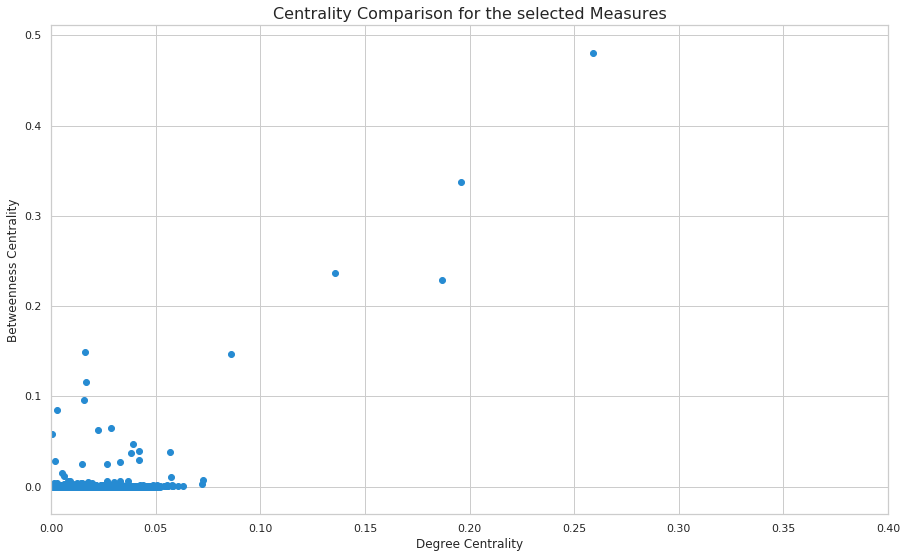

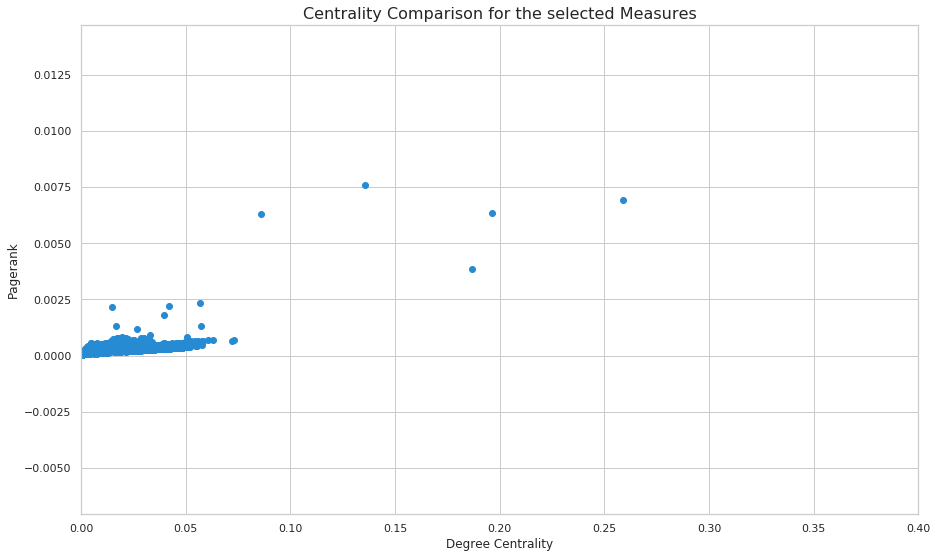

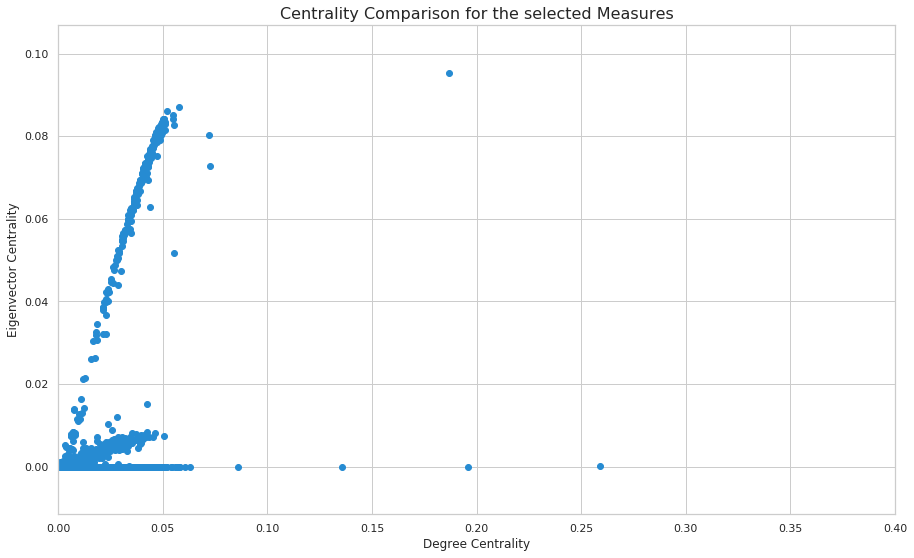

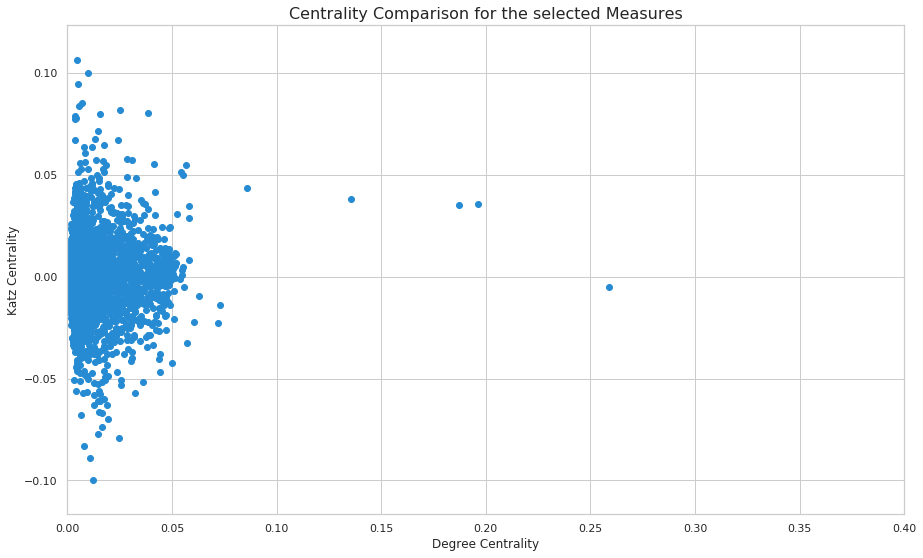

In [23]:
print("Degree vs Unweighted Centralities:")
plot_centrality(dc_G,bc_G,"Degree Centrality","Betweenness Centrality",0,0,0.4,0.02)
plot_centrality(dc_G,pr_G,"Degree Centrality","Pagerank",0,0,0.4,0.02)
plot_centrality(dc_G,ev_G,"Degree Centrality","Eigenvector Centrality",0,0,0.4,0.02)
plot_centrality(dc_G,katz_G,"Degree Centrality","Katz Centrality",0,0,0.4,0.02)

Centralitiy Comparison:


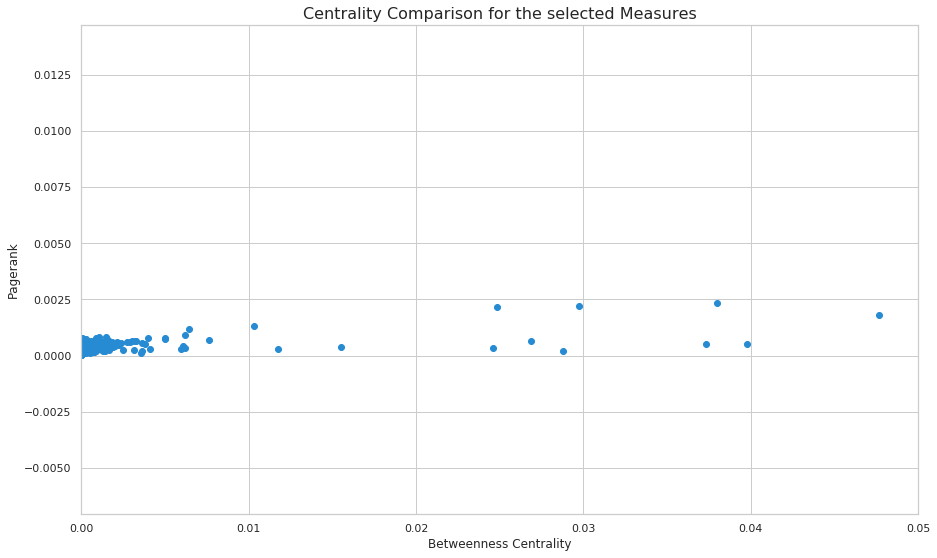

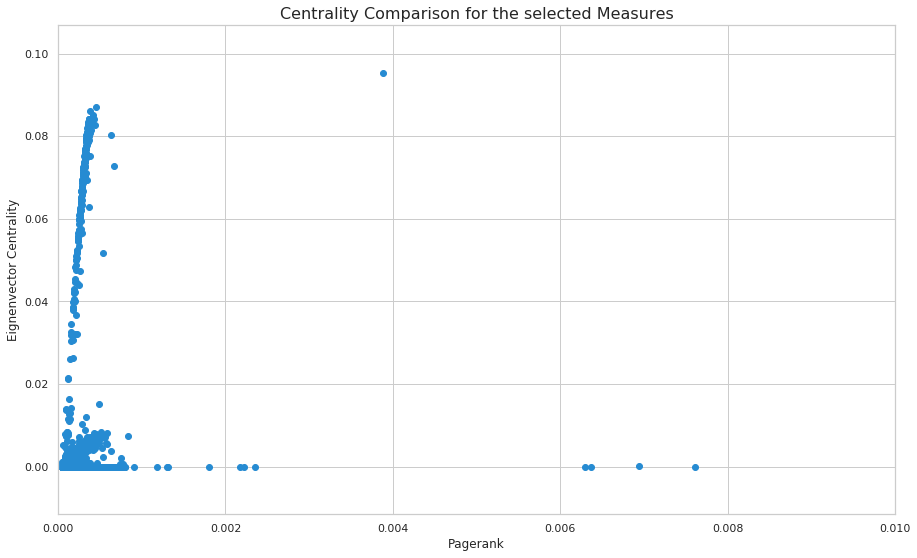

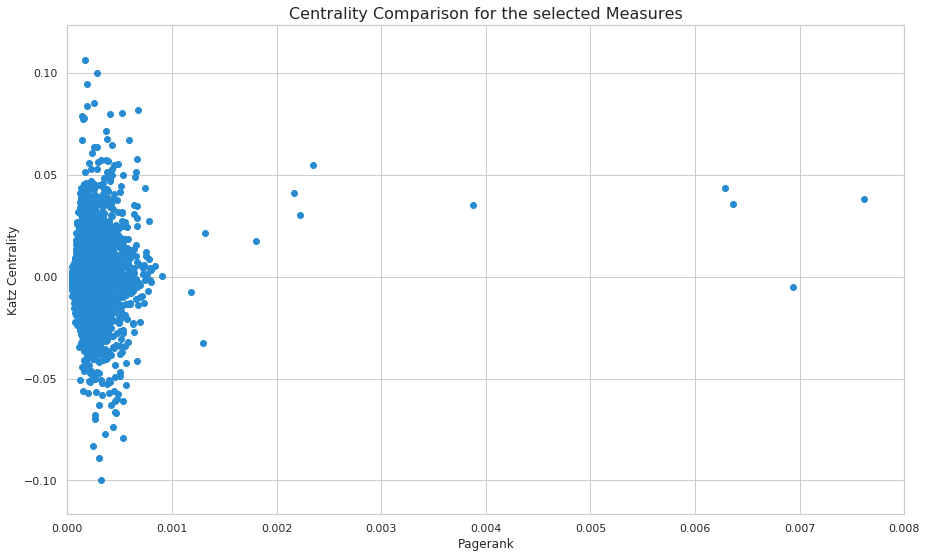

In [24]:
print("Centralitiy Comparison:")
plot_centrality(bc_G,pr_G,"Betweenness Centrality","Pagerank",0,0,0.05,0.02)
plot_centrality(pr_G,ev_G,"Pagerank","Eignenvector Centrality",0,0,0.01,0.02)
plot_centrality(pr_G,katz_G,"Pagerank","Katz Centrality",0,0,0.008,0.02)

Closeness Centrality:


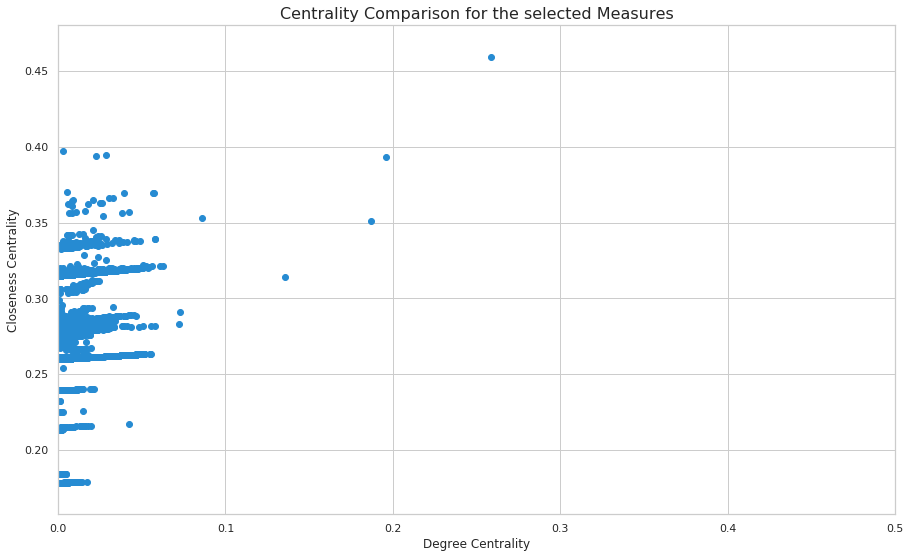

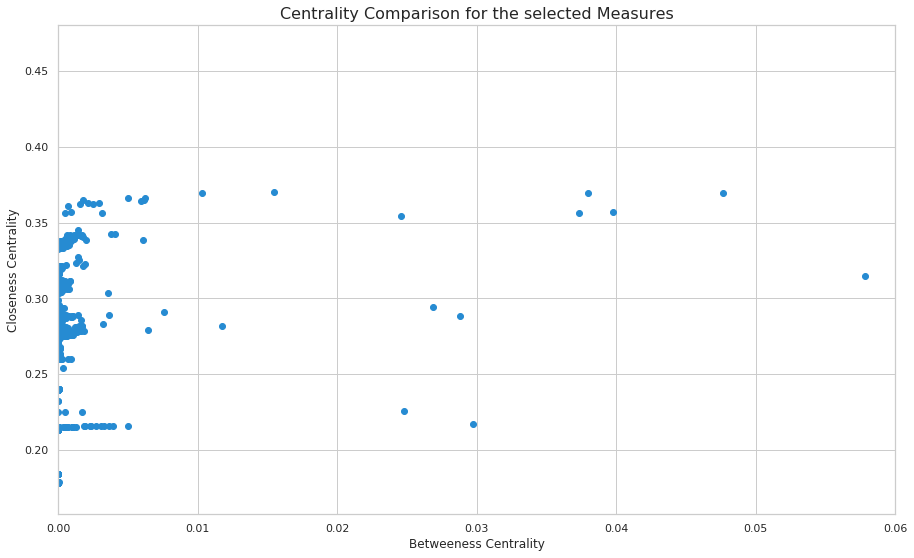

In [25]:
print("Closeness Centrality:")
plot_centrality(dc_G,cc_G,"Degree Centrality","Closeness Centrality",0,0,0.5,0.02)
plot_centrality(bc_G,cc_G,"Betweeness Centrality","Closeness Centrality",0,0,0.06,0.02)

#### Print top 10 entries according to measures

In [41]:
print("Degree Centrality")
print_top_10(dc_G,G_GCC)
S_dc=store_top_200(dc_G,G_GCC)


print("Closeness Centrality")
print_top_10(cc_G,G_GCC)
S_cc=store_top_200(cc_G,G_GCC)

print("Betweenness Centrality")
print_top_10(bc_G,G_GCC)
S_bc=store_top_200(bc_G,G_GCC)

print("Page Rank")
print_top_10(pr_G,G_GCC)
S_pr=store_top_200(pr_G,G_GCC)

print("Eigenvector Centrality")
print_top_10(ev_G,G_GCC)
S_ev=store_top_200(ev_G,G_GCC)

print("Katz Centrality")
print_top_10(katz_G,G_GCC)
S_katz=store_top_200(katz_G,G_GCC)

#S_xx stores the possible targets

Degree Centrality


,Node ID,Centrality Score
0,107,0.258791
1,1684,0.196137
2,1912,0.186974
3,3437,0.135463
4,0,0.085934
5,2543,0.072808
6,2347,0.072065
7,1888,0.062902
8,1800,0.060674
9,1663,0.058197


Closeness Centrality


,Node ID,Centrality Score
0,107,0.459699
1,58,0.397402
2,428,0.394837
3,563,0.393913
4,1684,0.393606
5,171,0.370493
6,348,0.369916
7,483,0.369848
8,414,0.369543
9,376,0.366558


Betweenness Centrality


,Node ID,Centrality Score
0,107,0.480518
1,1684,0.337797
2,3437,0.236115
3,1912,0.229295
4,1085,0.149015
5,0,0.146306
6,698,0.115330
7,567,0.096310
8,58,0.084360
9,428,0.064309


Page Rank


,Node ID,Centrality Score
0,3437,0.007615
1,107,0.006936
2,1684,0.006367
3,0,0.006290
4,1912,0.003877
5,348,0.002348
6,686,0.002219
7,3980,0.002170
8,414,0.001800
9,698,0.001317


Eigenvector Centrality


,Node ID,Centrality Score
0,1912,0.095406
1,2266,0.086983
2,2206,0.086053
3,2233,0.085173
4,2464,0.084279
5,2142,0.084193
6,2218,0.084156
7,2078,0.084136
8,2123,0.083672
9,1993,0.083533


Katz Centrality


,Node ID,Centrality Score
0,2696,0.106398
1,2921,0.099801
2,2934,0.094739
3,3275,0.085035
4,2870,0.083750
5,2951,0.081817
6,1718,0.080273
7,3274,0.080043
8,3246,0.078651
9,2697,0.077689


In [42]:
print(S_dc)
print(S_cc)
print(S_bc)
print(S_pr)
print(S_ev)
print(S_katz)


    Node ID  Centrality Score
0       107          0.258791
1      1684          0.196137
2      1912          0.186974
3      3437          0.135463
4         0          0.085934
5      2543          0.072808
6      2347          0.072065
7      1888          0.062902
8      1800          0.060674
9      1663          0.058197
10     1352          0.057949
11     2266          0.057949
12      483          0.057207
13      348          0.056711
14     1730          0.055968
15     1985          0.055473
16     1941          0.055225
17     2233          0.054978
18     2142          0.054730
19     1431          0.054482
20     1199          0.053739
21     1584          0.052254
22     2206          0.052006
23     1768          0.051758
24     2229          0.051263
25     2410          0.051263
26     2611          0.051263
27     1086          0.050768
28     1589          0.050768
29     2047          0.050768
..      ...               ...
170    2446          0.039871
171    254

#### Degree correlation over Focus Categories

In [27]:
print("\nOverall Correlation Coefficient:",np.round(nx.degree_pearson_correlation_coefficient(G_GCC),3))


Overall Correlation Coefficient: 0.064


# 3. Community Detection

In [28]:
# NOT IMPLEMENTED - TOO SLOW
#list_clique_communities = list(k_clique_communities(G2_GCC, k=15))
#list_clique_communities

In [29]:
np.random.seed(5000)

In [30]:
#nx.greedy_modularity_communities(G_GCC, weight=None)

In [31]:
partition = community.best_partition(G_GCC, resolution=1.2,  random_state=5000)
labels = set(partition.values())
community_counts = {i: list(partition.values()).count(i) for i in labels}
community_counts

{0: 344,
 1: 428,
 2: 560,
 3: 447,
 4: 442,
 5: 320,
 6: 122,
 7: 548,
 8: 73,
 9: 237,
 10: 25,
 11: 61,
 12: 206,
 13: 226}

In [32]:
#print(partition)

In [33]:
T = []
for i in range(len(labels)):    
    c = [nodes for nodes in partition.keys() if partition[nodes] == i]
    T.append(G_GCC.subgraph(c))

In [34]:
corr_list2 =[nx.degree_pearson_correlation_coefficient(T[l]) for l in range(len(T))]
a = [print('Community:',l,'has correlation coefficient:',corr_list2[l]) for l in range(len(corr_list2))]

Community: 0 has correlation coefficient: -0.1419372649407304
Community: 1 has correlation coefficient: 0.0004111537071744188
Community: 2 has correlation coefficient: -0.07496431130289084
Community: 3 has correlation coefficient: -0.051350732718525256
Community: 4 has correlation coefficient: 0.01411083312985816
Community: 5 has correlation coefficient: 0.13363179811554474
Community: 6 has correlation coefficient: 0.49302625973918907
Community: 7 has correlation coefficient: -0.09288000605967493
Community: 8 has correlation coefficient: -0.07462914279980881
Community: 9 has correlation coefficient: 0.0013672180351790538
Community: 10 has correlation coefficient: -0.12420387339962305
Community: 11 has correlation coefficient: -0.2840661133551881
Community: 12 has correlation coefficient: -0.11409190052678135
Community: 13 has correlation coefficient: 0.13655252663884707


#### Community Layout Plot and Induced Community Graph

<b>NOTE: Takes a relatively long time to plot (2-5 min)</b>

In [35]:
# Some fancy code for inferring node position based on communities
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx/43541777
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos



In [52]:
def plot_communities(G):
    #colormap2 = np.array(["magenta", "yellow", "red", "white", "black", "cyan"])#, "#6e6cd5", "#e3be38"])
    p = cm.get_cmap('jet', len(set(partition.values())))
    colormap = np.array(p(np.arange(len(set(partition.values())))))[:len(set(partition.values()))]
    colormap2 = [rgb2hex(colormap[i,:]) for i in range(colormap.shape[0])]
    plt.figure(figsize=(25,25))
    pos = community_layout(G, partition)

    count = 0
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, alpha=0.6, node_color = colormap2[count], label = 'Community '+str(count))
        count = count + 1

    nx.draw_networkx_edges(G, pos, alpha=0.10,  edge_color='k')

    plt.legend()
    plt.axis('off')
    plt.title('Plot of inter-community link weights')
    plt.show()



/home/herculez/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


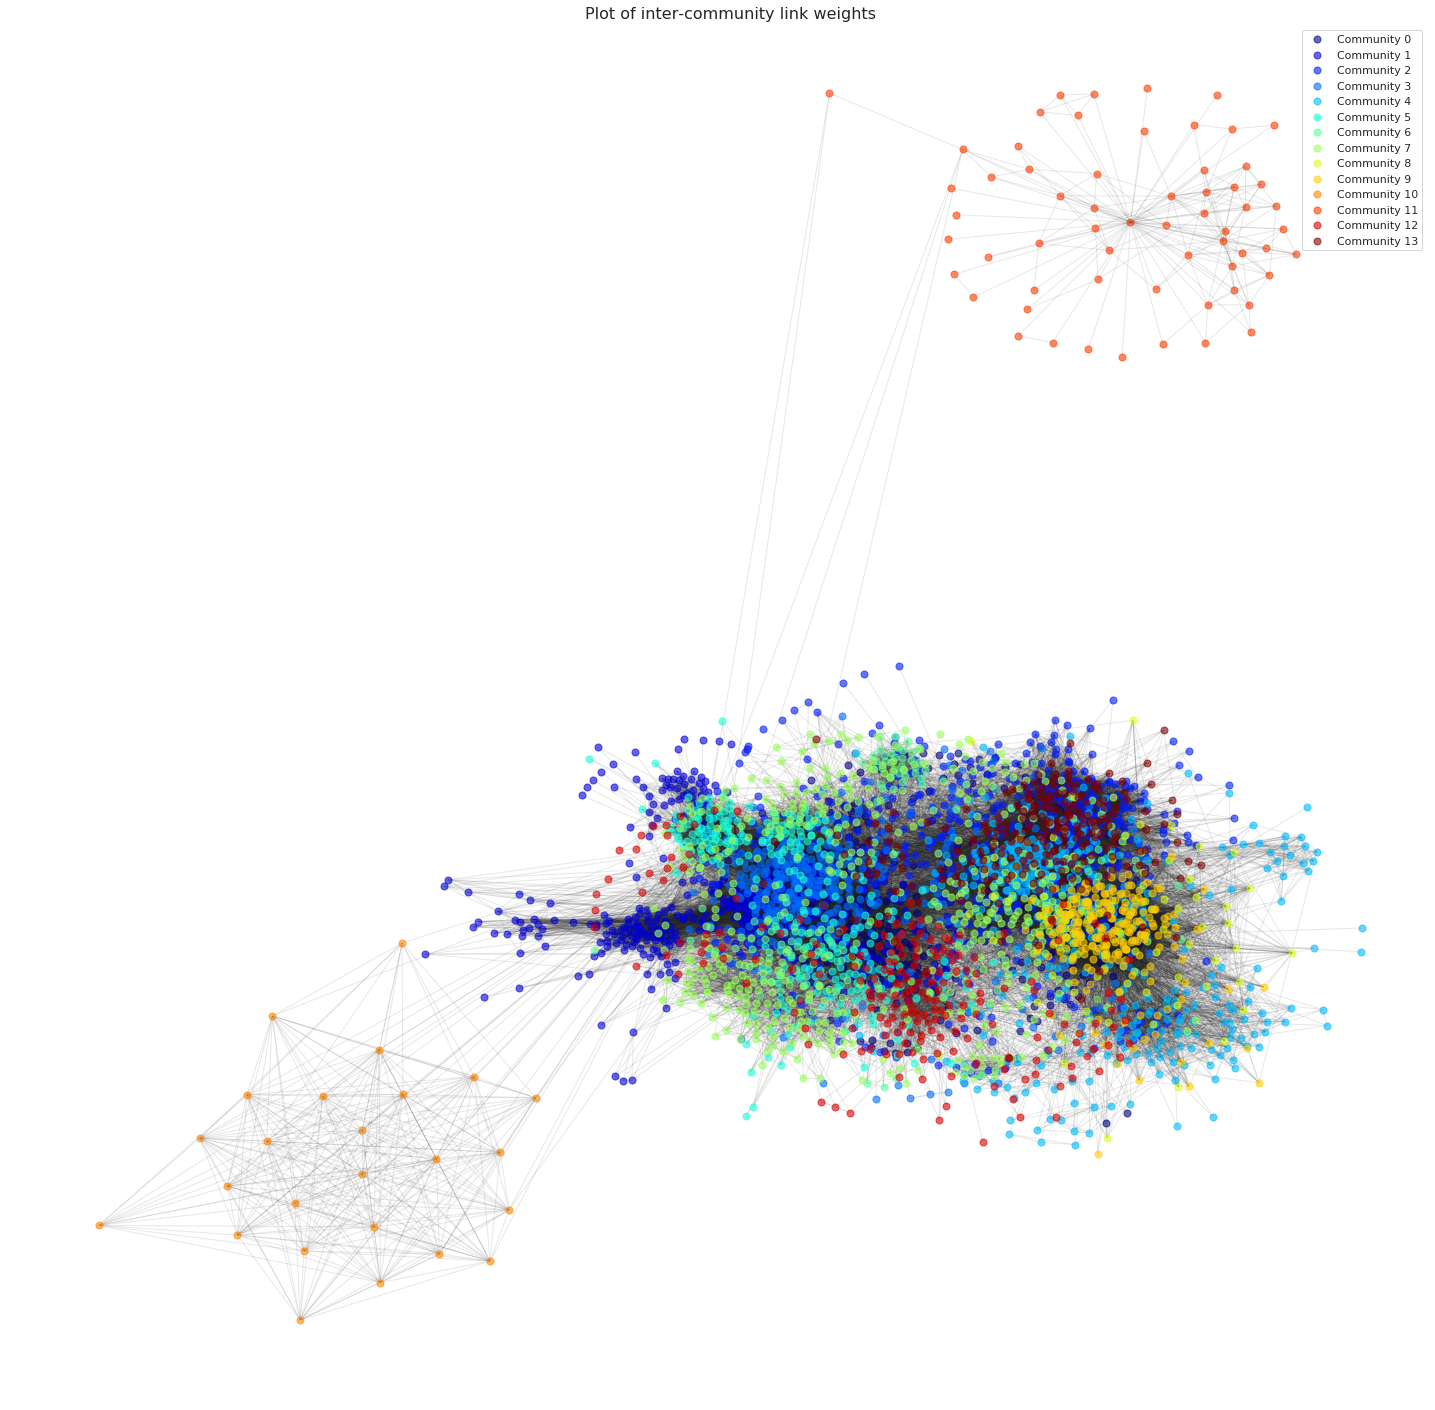

In [53]:
plot_communities(G_GCC)

/home/herculez/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


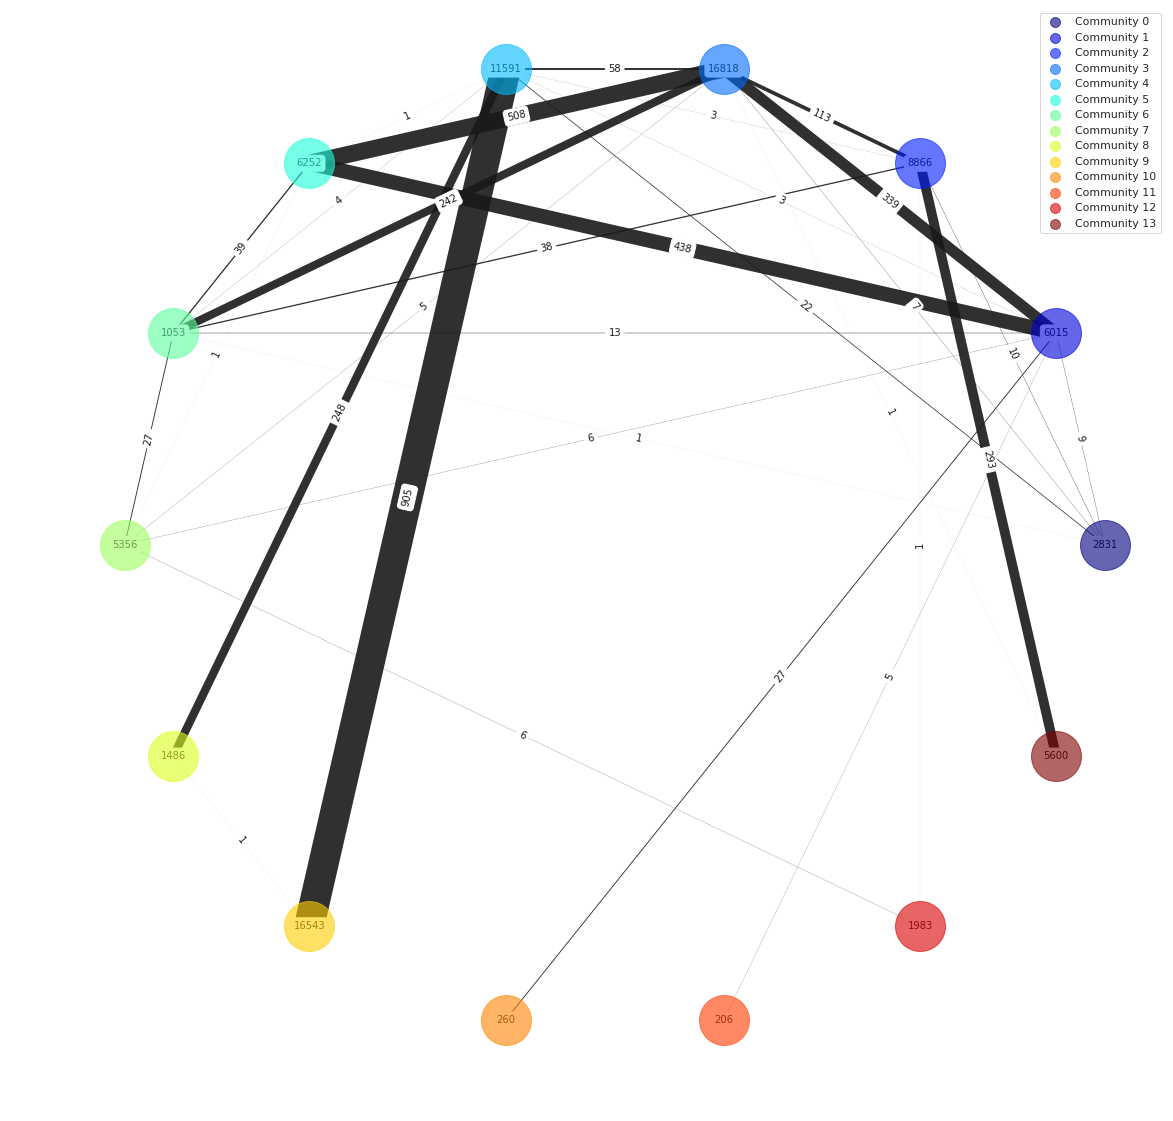

In [51]:
T_com = community.induced_graph(partition, G_GCC, weight='weight')
def plot_graph(G):
    plt.figure(figsize=(20,20))
    pos = nx.circular_layout(G)
    
    p = cm.get_cmap('jet', len(set(partition.values())))
    colormap = np.array(p(np.arange(len(set(partition.values())))))[:len(set(partition.values()))]
    colormap2 = [rgb2hex(colormap[i,:]) for i in range(colormap.shape[0])]
    #colormap2 = np.array(["magenta", "yellow", "red", "white", "black", "cyan"])#, "#6e6cd5", "#e3be38"])

    # plot nodes
    #nx.draw_networkx_nodes(G, pos, node_color='orange',node_size=2000, alpha=0.5)
    count = 0
    for com in set(partition.values()) :
        #list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G_GCC, pos, nodelist=[count], node_size = 2500, alpha=0.6, node_color = colormap2[count], label = 'Community '+str(count))
        count = count + 1
    
    # plot edges with widths depending on weights
    nx.draw_networkx_edges(G, pos, edge_color='k', alpha=0.9, width = [d['weight']/30 for u,v,d in G.edges(data=True)])

    # add edges' labels with weights
    edge_labels=dict([((u,v), d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.axis('off')
    plt.legend(markerscale=0.2)
    plt.show()

plot_graph(T_com)

In [56]:
count = 0
for t in T:
    print("Community number",count)
    dc_t = nx.degree_centrality(t)
    print_top_10(dc_t,t)
    count = count + 1


Community number 0


,Node ID,Centrality Score
0,0,0.994169
1,56,0.224490
2,67,0.218659
3,271,0.212828
4,322,0.206997
5,25,0.201166
6,26,0.198251
7,252,0.189504
8,277,0.189504
9,21,0.186589


Community number 1


,Node ID,Centrality Score
0,348,0.529274
1,483,0.362998
2,414,0.304450
3,376,0.299766
4,475,0.278689
5,428,0.248244
6,517,0.236534
7,412,0.229508
8,353,0.224824
9,373,0.220141


Community number 2


,Node ID,Centrality Score
0,1684,0.998211
1,3101,0.218247
2,3291,0.212880
3,3082,0.207513
4,2742,0.207513
5,3397,0.205725
6,3320,0.202147
7,3434,0.191413
8,3280,0.191413
9,3116,0.184258


Community number 3


,Node ID,Centrality Score
0,107,1.000000
1,1888,0.567265
2,1800,0.542601
3,1663,0.524664
4,1352,0.520179
5,1730,0.504484
6,1431,0.493274
7,1199,0.484305
8,1768,0.468610
9,1589,0.459641


Community number 4


,Node ID,Centrality Score
0,1912,1.000000
1,2047,0.455782
2,2111,0.412698
3,2384,0.412698
4,2199,0.390023
5,2081,0.376417
6,2598,0.367347
7,2054,0.365079
8,2328,0.362812
9,2283,0.358277


Community number 5


,Node ID,Centrality Score
0,896,0.382445
1,1277,0.376176
2,1783,0.369906
3,917,0.360502
4,1104,0.332288
5,1204,0.326019
6,1235,0.319749
7,1459,0.313480
8,1583,0.300940
9,1014,0.300940


Community number 6


,Node ID,Centrality Score
0,1687,0.305785
1,1837,0.297521
2,1548,0.297521
3,1733,0.297521
4,1895,0.289256
5,1097,0.289256
6,1118,0.280992
7,1216,0.280992
8,1787,0.272727
9,901,0.272727


Community number 7


,Node ID,Centrality Score
0,3437,0.996344
1,3830,0.197441
2,3596,0.157221
3,3938,0.151737
4,3545,0.151737
5,3604,0.138940
6,3684,0.122486
7,3633,0.118830
8,3838,0.111517
9,3756,0.111517


Community number 8


,Node ID,Centrality Score
0,2364,0.861111
1,2171,0.861111
2,1951,0.847222
3,1972,0.819444
4,1995,0.819444
5,2001,0.777778
6,1973,0.777778
7,1980,0.763889
8,2284,0.750000
9,1927,0.736111


Community number 9


,Node ID,Centrality Score
0,2266,0.940678
1,2142,0.881356
2,2206,0.881356
3,2233,0.872881
4,2410,0.864407
5,2218,0.860169
6,2611,0.855932
7,2078,0.851695
8,2123,0.851695
9,2229,0.851695


Community number 10


,Node ID,Centrality Score
0,583,1.000000
1,658,0.958333
2,659,0.958333
3,578,0.958333
4,627,0.958333
5,662,0.958333
6,600,0.958333
7,661,0.958333
8,615,0.958333
9,643,0.958333


Community number 11


,Node ID,Centrality Score
0,3980,0.983333
1,4030,0.316667
2,4023,0.300000
3,3982,0.233333
4,3998,0.233333
5,4014,0.200000
6,4021,0.183333
7,4031,0.183333
8,3994,0.183333
9,3997,0.183333


Community number 12


,Node ID,Centrality Score
0,686,0.829268
1,828,0.385366
2,713,0.346341
3,705,0.336585
4,805,0.321951
5,719,0.312195
6,698,0.307317
7,824,0.282927
8,745,0.278049
9,747,0.278049


Community number 13


,Node ID,Centrality Score
0,2839,0.604444
1,3363,0.573333
2,2754,0.524444
3,3426,0.497778
4,3090,0.471111
5,2966,0.471111
6,2944,0.466667
7,3232,0.462222
8,2877,0.457778
9,2786,0.448889
